In [36]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
import time

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.5.0
sys.version_info(major=3, minor=7, micro=11, releaselevel='final', serial=0)
matplotlib 3.2.2
numpy 1.19.5
pandas 1.1.5
sklearn 0.22.2.post1
tensorflow 2.5.0
tensorflow.keras 2.5.0


# 新段落

In [37]:
import unicodedata
import re
from sklearn.model_selection import train_test_split

In [38]:
#因为西班牙语有一些是特殊字符，所以我们需要unicode转ascii，
# 这样值变小了，因为unicode太大
def unicode_to_ascii(s):
    #NFD是转换方法，把每一个字节拆开，Mn是重音，所以去除
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

#下面我们找个样本测试一下

en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"

print(unicode_to_ascii(en_sentence))
print(unicode_to_ascii(sp_sentence))


def preprocess_sentence(w):
    #变为小写，去掉多余的空格
    w = unicode_to_ascii(w.lower().strip())

    # 在单词与跟在其后的标点符号之间插入一个空格
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    #因为可能有多余空格，所以处理一下
    w = re.sub(r'[" "]+', " ", w)

    # 除了 (a-z, A-Z, ".", "?", "!", ",")，将所有字符替换为空格
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

May I borrow this book?
¿Puedo tomar prestado este libro?
<start> may i borrow this book ? <end>
<start> ¿ puedo tomar prestado este libro ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [39]:
!ls

8-1_checkpoints  sample_data  spa.txt


In [40]:
list(zip(*[[1,2],[3,4],[5,6]]))

[(1, 3, 5), (2, 4, 6)]

In [41]:
data_path = './spa.txt'

# 1. Remove the accents  移除口音
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]--> 前面西班牙，后面英文
def create_dataset(path, num_examples):
    #每一行在列表中就是一个元素
    lines = open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

    return zip(*word_pairs)

en, sp = create_dataset(data_path, 30000)  #所有英语语料集放在en，西班牙语放在sp里边
print(type(en))
print(type(sp))
len(en)
print(en[-1])
print(sp[-1])


<class 'tuple'>
<class 'tuple'>
<start> we ll see you at . <end>
<start> te veremos a las dos y media . <end>


In [42]:
#如何理解上面的zip
a=[ [1, 2],[3,4],[5,6] ]
c,d=zip(*a)
print(c,d)


(1, 3, 5) (2, 4, 6)


In [43]:
def max_length(tensor):
    return max(len(t) for t in tensor)
#把单词变为id，同时增加padding
def tokenize(lang):
    #Tokenizer帮我们把词语式的转换为id式的，filters是黑名单
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang) #提取的过程
    #text会变为id
    tensor = lang_tokenizer.texts_to_sequences(lang)
    #做padding
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor, lang_tokenizer

def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    targ_lang, inp_lang = create_dataset(path, num_examples)  #上面的create_dataset

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)  #input_tensor是西班牙语的id，inp_lang_tokenizer后面需要使用的
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)  #

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

# Try experimenting with the size of that dataset
num_examples = 30000
#inp_lang  targ_lang 是tokenizer
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(data_path, num_examples)
print('-'*50)
print(input_tensor.shape, target_tensor.shape, inp_lang, targ_lang)
print('-'*50)
print(input_tensor[0])
print(target_tensor[0])
print(input_tensor[29999])
print(target_tensor[29999])
# Calculate max_length of the target tensors，可以看下最长的样本
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)
print(max_length_targ, max_length_inp)

--------------------------------------------------
(30000, 16) (30000, 11) <keras_preprocessing.text.Tokenizer object at 0x7f71f774cb90> <keras_preprocessing.text.Tokenizer object at 0x7f7255a34950>
--------------------------------------------------
[  1 135   3   2   0   0   0   0   0   0   0   0   0   0   0   0]
[ 1 36  3  2  0  0  0  0  0  0  0]
[   1   23 2175   10   39   98   87  314    3    2    0    0    0    0
    0    0]
[ 1 16 38 72  6 55  3  2  0  0  0]
11 16


In [44]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2,random_state=1)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(24000, 24000, 6000, 6000)

In [45]:
#按单词进行切分的
def convert(lang, tensor):
    for t in tensor:
        #不等于0，就打印转换
        if t != 0:
            print ("%d ----> %s" % (t, lang.index_word[t]))
            
print("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])  #通过tokenizer把id变为text
print()
print("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])
#可以发现tokenizer正常工作

Input Language; index to word mapping
1 ----> <start>
53 ----> quiero
72 ----> ir
269 ----> contigo
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
4 ----> i
47 ----> want
15 ----> to
36 ----> go
80 ----> with
6 ----> you
3 ----> .
2 ----> <end>


In [46]:
#分batch
BUFFER_SIZE = len(input_tensor_train)  #就是3万
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
#输入的，加1是为了对于0的填充
vocab_inp_size = len(inp_lang.word_index)+1
print(vocab_inp_size)
#输出
vocab_tar_size = len(targ_lang.word_index)+1
print(vocab_tar_size)
#训练集
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

9414
4935
<BatchDataset shapes: ((64, 16), (64, 11)), types: (tf.int32, tf.int32)>


In [47]:
#测试，看一下迭代
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

In [48]:
#手法和之前的类似
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, encoding_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        #编码单元
        self.encoding_units = encoding_units
        #创建Embedding层
        self.embedding = keras.layers.Embedding(vocab_size, embedding_dim)
        #定义GRU层，gru是lstm变种，gru把遗忘门和输入门变为一个，因为遗忘门+输入门=1
        #
        self.gru = keras.layers.GRU(self.encoding_units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.encoding_units))
    
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
#获得初始化的hidden
sample_hidden = encoder.initialize_hidden_state()
#获得输出和隐含状态，对encoder加括号，就会调用call
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
#输出的16是长度，1024是状态的size
print('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [49]:
#理解模型中去做的运算
encoder.variables

[<tf.Variable 'encoder_2/embedding_5/embeddings:0' shape=(9414, 256) dtype=float32, numpy=
 array([[ 0.04052639,  0.01803826, -0.04961072, ...,  0.0402065 ,
          0.03619694,  0.03959731],
        [-0.01159988,  0.02840433, -0.04033406, ...,  0.01290822,
         -0.03819864, -0.0194662 ],
        [ 0.04376108, -0.02927834,  0.03755097, ...,  0.01492551,
         -0.02872068,  0.04890319],
        ...,
        [ 0.02108837,  0.01565559,  0.02045467, ...,  0.01657638,
          0.00504558, -0.03979783],
        [-0.04720401,  0.00185975,  0.02732427, ...,  0.03491405,
         -0.02022424,  0.03580972],
        [ 0.02699428, -0.03925722, -0.0199117 , ...,  0.03078567,
          0.0115645 ,  0.01434696]], dtype=float32)>,
 <tf.Variable 'encoder_2/gru_5/gru_cell_5/kernel:0' shape=(256, 3072) dtype=float32, numpy=
 array([[-0.02316775, -0.03724046, -0.00069578, ...,  0.01614526,
          0.01107113, -0.01293691],
        [-0.03862314,  0.02014733,  0.00025981, ...,  0.01814352,
      

In [50]:
#实现Attention机制
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        #做全连接
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
    
    #query传的是decoder_ hidden
    def call(self, query, values):
        # deocoder_ hidden. shape: (batch_ size,units )
        # encoder outputs.shape: ( batch size, length,units )
        #做维度扩展，扩展前后对比是下面两行
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(query, 1)
        
        #接下来要实现Attention,Bahdanau方式的
        # beforeV:(batch_ size,length,units )
        # after V( batch_ size,length,1)
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        #先算加权，values就是encoder_outputs
        # context_vector.shape: ( batch size, length units )
        context_vector = attention_weights * values
        # print(context_vector.shape)
        #在length的维度去求和
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights
    
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


In [51]:
attention_layer.variables

[<tf.Variable 'bahdanau_attention_5/dense_18/kernel:0' shape=(1024, 10) dtype=float32, numpy=
 array([[ 0.07223897,  0.01506744,  0.03008816, ..., -0.03833292,
         -0.04927295, -0.07279775],
        [ 0.07380407, -0.05921623, -0.00688946, ...,  0.04153791,
          0.02634648, -0.03771466],
        [ 0.07299037,  0.06669419, -0.0109436 , ..., -0.06361956,
          0.07494099, -0.06264533],
        ...,
        [-0.04482927,  0.04413758,  0.03248977, ..., -0.01064533,
          0.03130363, -0.02761006],
        [-0.03393735, -0.06770609,  0.04458857, ...,  0.01335265,
         -0.03186403,  0.02174255],
        [-0.06814168, -0.05552623, -0.05991594, ...,  0.01839887,
          0.00930812,  0.01312785]], dtype=float32)>,
 <tf.Variable 'bahdanau_attention_5/dense_18/bias:0' shape=(10,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>,
 <tf.Variable 'bahdanau_attention_5/dense_19/kernel:0' shape=(1024, 10) dtype=float32, numpy=
 array([[-0.073251

In [52]:
#接着我们实现decoder
class Decoder(tf.keras.Model):
    #init传参和encoder很像
    def __init__(self, vocab_size, embedding_dim, decoding_units, batch_size):
        #这里必须调用父类
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.decoding_units = decoding_units
        #Embedding 层
        self.embedding = keras.layers.Embedding(vocab_size, embedding_dim)
        #GRU的decoder
        self.gru = keras.layers.GRU(self.decoding_units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
        self.fc = keras.layers.Dense(vocab_size)

        # used for attention，每一步都会被调用
        self.attention = BahdanauAttention(self.decoding_units)

    #照着原来的原理图理解
    def call(self, x, hidden, encoding_output):
        # context vector. shape: ( batch size, units）
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, encoding_output)

        # before embedding: x. shape: (batch_ size, 1 )
        # after embedding : x. shape: (batch size, 1， embedding units)
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        # print(context_vector.shape,x.shape)  #为了理解
        #把x和context_vector拼起来，context_vector为什么要扩展维度？
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        # print(x.shape)#为了理解
        # passing the concatenated vector to the GRU
        # output. shape:[batch_size,1,decoding_units ]
        #state. shape:[batch_size, decoding_units ]
        output, state = self.gru(x)
        # print(output.shape)#为了理解
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        # print('output变换后')
        # print(output.shape)
        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
sample_decoder_output,decoder_hidden,decoder_aw = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)
print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))
print( "decoder_hidden.shape: ",decoder_hidden.shape )
print( "decoder_attention_weights.shape:",decoder_aw.shape )


Decoder output shape: (batch_size, vocab size) (64, 4935)
decoder_hidden.shape:  (64, 1024)
decoder_attention_weights.shape: (64, 16, 1)


In [53]:
#我们用的优化器是adam
optimizer = keras.optimizers.Adam()
#分类问题我们往往用SparseCategoricalCrossentropy，因为我们的fc是纯的输出，没有加softmax，
# 因此这里的from_logits为True，否则改为false，reduction是损失函数如何做聚合
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    #是零的时候返回结果是True，因此要取反操作
    #tf.math.equal(real, 0)是padding的部分都是1，不是padding的部分都是零，因此我们要取反
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    
    loss_ = loss_object(real, pred)
    #将张量转换为新类型,变为float类型
    mask = tf.cast(mask, dtype=loss_.dtype)
    #padding部分的mask是零
    loss_ *= mask
    #计算累计的损失平均
    return tf.reduce_mean(loss_)

checkpoint_dir = './8-1_checkpoints'
if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [54]:
tf.math.logical_not(tf.math.equal([12,13,67,0,0], 0))

<tf.Tensor: shape=(5,), dtype=bool, numpy=array([ True,  True,  True, False, False])>

In [55]:
tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

<tf.Tensor: shape=(64, 1), dtype=int32, numpy=
array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=int32)>

In [56]:
@tf.function
def train_step(inp, targ, encoding_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        #把输入给encoder，得到encoding_output, encoding_hidden
        encoding_output, encoding_hidden = encoder(inp, encoding_hidden)

        decoding_hidden = encoding_hidden
        #第一次给进去的decoding_input全部是1，是64个1
        decoding_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
        
        #eg: <start> I am here <end>
        #1.<start>->I
        #2.I->am
        #3.am->here
        # 4. here ->< end>
        #对于here，我们相当于要把I am  的信息都要给过去
        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            #根据我们前面的原理解析，我们这里需要给3项信息
            predictions, decoding_hidden, _ = decoder(decoding_input, decoding_hidden, encoding_output)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            decoding_input = tf.expand_dims(targ[:, t], 1)
            
    #这里是每个batch上平均的损失函数
    batch_loss = (loss / int(targ.shape[1]))
    #因为继承了model类，所以可以拿到trainable_variables
    variables = encoder.trainable_variables + decoder.trainable_variables
    #求梯度
    gradients = tape.gradient(loss, variables)
    #有了梯度以后，可以用optimizer去做apply
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [57]:
steps_per_epoch

375

In [58]:
EPOCHS = 10
#这里运行时间比较久
for epoch in range(EPOCHS):
    start = time.time()

    encoding_hidden = encoder.initialize_hidden_state()#第一次，全零的隐含状态
    total_loss = 0
    #每次去取dataset.take(steps_per_epoch)这么多数据
    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        # print(targ.shape)
        batch_loss = train_step(inp, targ, encoding_hidden)
        total_loss += batch_loss
        #这里增加打印
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs，保存模型
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.6625
Epoch 1 Batch 100 Loss 2.1023
Epoch 1 Batch 200 Loss 1.8525
Epoch 1 Batch 300 Loss 1.7416
Epoch 1 Loss 2.0631
Time taken for 1 epoch 46.2464325428009 sec

Epoch 2 Batch 0 Loss 1.6007
Epoch 2 Batch 100 Loss 1.5514
Epoch 2 Batch 200 Loss 1.4265
Epoch 2 Batch 300 Loss 1.4079
Epoch 2 Loss 1.4560
Time taken for 1 epoch 34.957958936691284 sec

Epoch 3 Batch 0 Loss 1.1550
Epoch 3 Batch 100 Loss 1.0865
Epoch 3 Batch 200 Loss 1.0195
Epoch 3 Batch 300 Loss 0.8749
Epoch 3 Loss 1.0551
Time taken for 1 epoch 34.750760078430176 sec

Epoch 4 Batch 0 Loss 0.8121
Epoch 4 Batch 100 Loss 0.7748
Epoch 4 Batch 200 Loss 0.6992
Epoch 4 Batch 300 Loss 0.6797
Epoch 4 Loss 0.7140
Time taken for 1 epoch 35.14546036720276 sec

Epoch 5 Batch 0 Loss 0.5139
Epoch 5 Batch 100 Loss 0.5351
Epoch 5 Batch 200 Loss 0.4593
Epoch 5 Batch 300 Loss 0.5044
Epoch 5 Loss 0.4865
Time taken for 1 epoch 34.76838779449463 sec

Epoch 6 Batch 0 Loss 0.3184
Epoch 6 Batch 100 Loss 0.3345
Epoch 6 Batch 200 Los

In [59]:
#接收字符串，并进行翻译
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    #对输入的语言做和训练时同样的预处理后，再进行word转id
    sentence = preprocess_sentence(sentence)
    #text到id的转换
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    #加padding
    inputs = keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    #结果先初始化一个空串
    result = ''

    hidden = [tf.zeros((1, units))]
    encoding_out, encoding_hidden = encoder(inputs, hidden)
    #按模型把encoding_hidden给decoding_hidden
    decoding_hidden = encoding_hidden
    #第一次的decoding_input是全为1的（64,1)的矩阵
    decoding_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)
    #eg:<start>->A
    #A->B->C-> D
    # decoding_ input. shape:(1， 1)
    for t in range(max_length_targ):
        predictions, decoding_hidden, attention_weights = decoder(
            decoding_input, decoding_hidden, encoding_out)
        
        # attention weights. shape: (batch size, input length, 1) (1， 16， 1 )，需要变为长度为16的向量
        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy() #为了画图
        # predictions.shape: (batch_ size, vocab_ size) (1， 4935)
        #获取概率最大的值作为下一步的输入
        predicted_id = tf.argmax(predictions[0]).numpy()
        #通过id知道单词
        result += targ_lang.index_word[predicted_id] + ' '
        
        #终止循环
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        decoding_input = tf.expand_dims([predicted_id], 0)
    #到此decoding_input，decoding_hidden我们都做了更新
    
    return result, sentence, attention_plot

# function for plotting the attention weights，把注意力关系完成可视化
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}
    #把标注写上，我们需要把第零个位置空出来，看图即可看出
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

#通过这个函数，把上面两个函数串起来
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    #因为输出不一定有输入的长度长，也就是result长度小于输入的长度
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))
    

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold here . <end> 


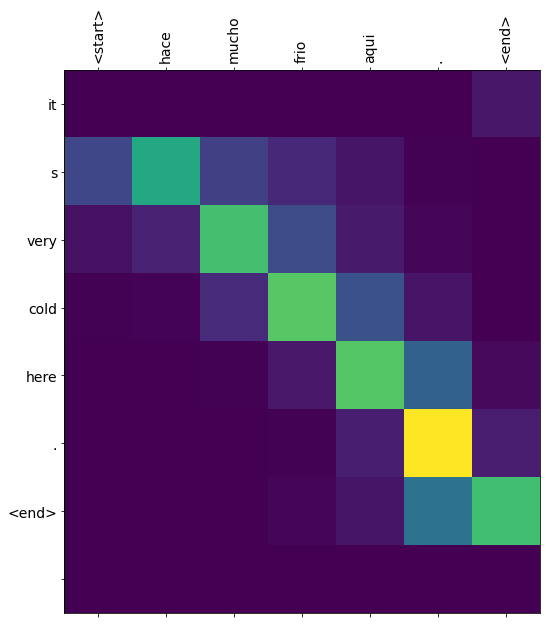

In [60]:
#it is terribly cold here
translate(u'hace mucho frio aqui.')

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


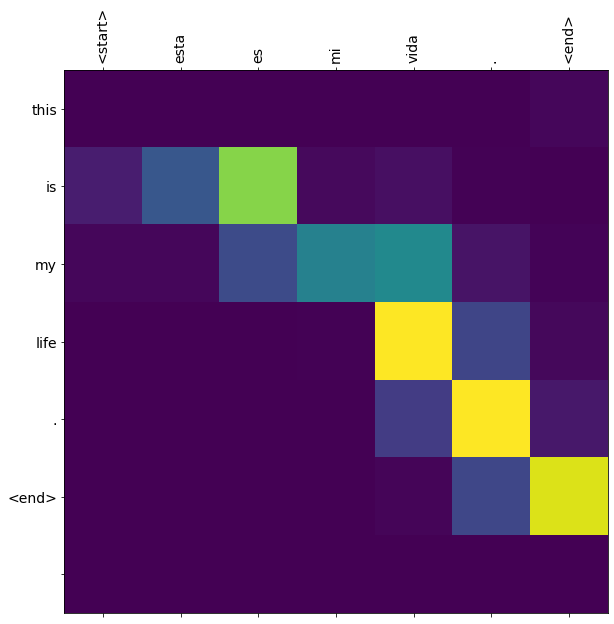

In [61]:
translate(u'esta es mi vida.')

Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: are you still at home ? <end> 


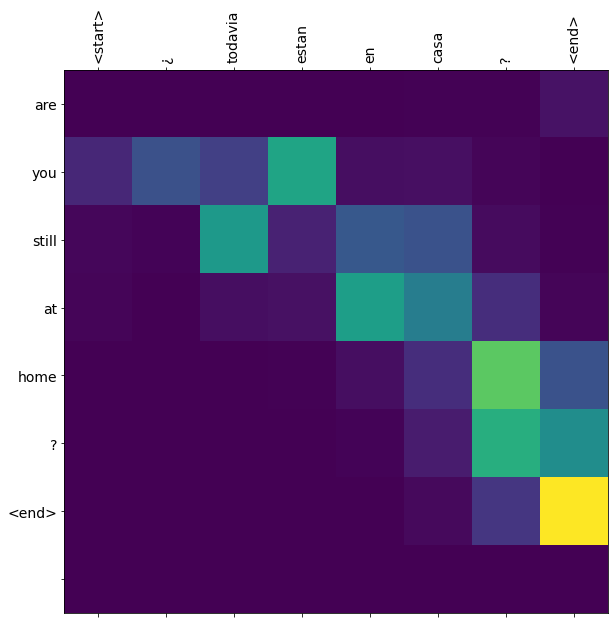

In [62]:
translate(u'¿todavia estan en casa?')

Input: <start> trata de averiguarlo . <end>
Predicted translation: try to figure it out . <end> 


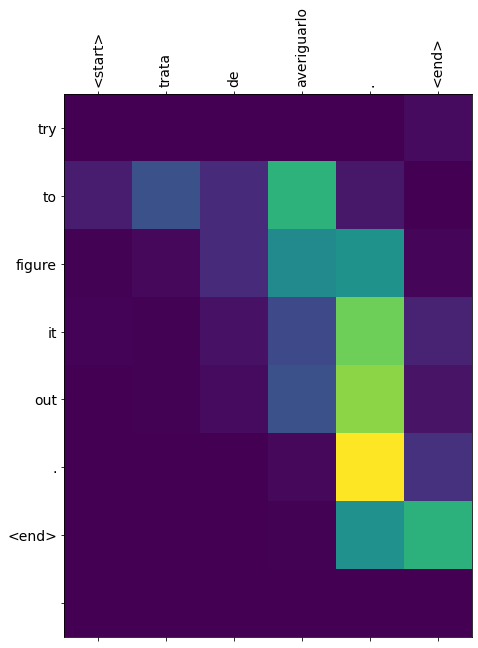

In [63]:
translate(u'trata de averiguarlo.')

Input: <start> hoy es un buen dia <end>
Predicted translation: today is a good day now . <end> 


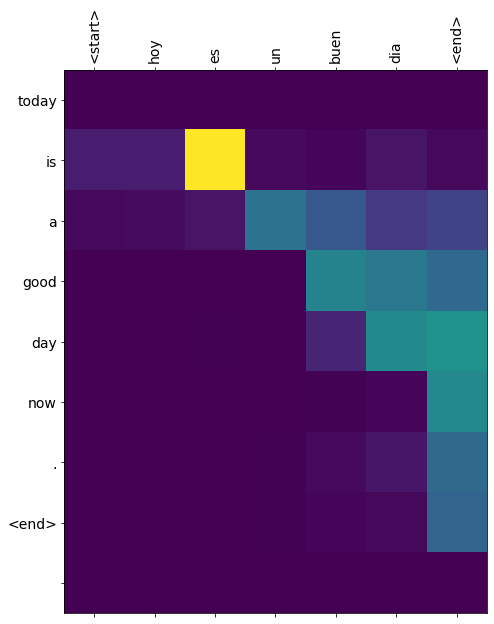

In [64]:
translate(u'Hoy es un buen día')